**Paris-Specific Features Engineering**

Section 1: Imports and Configuration

In [0]:
import numpy as np
import pandas as pd
from sklearn.neighbors import BallTree
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType

In [0]:
# ============================================================================
# SECTION 1: LOAD CLEANED DATASETS 
# ============================================================================

print("Loading cleaned datasets from Data Analysis notebook...\n")

BASE_PATH = "/FileStore/tables/paris_project"

try:
    local_train_spark = spark.read.parquet(f"{BASE_PATH}/gold/local_train_pool_v4.parquet")
    test_spark = spark.read.parquet(f"{BASE_PATH}/gold/test_set_v4.parquet")
    
    print("v4 FILES SUCCESSFULLY LOADED")
    print(f"   • local_train_pool_v4: {local_train_spark.count():,} rows × {len(local_train_spark.columns)} columns")
    print(f"   • test_set_v4: {test_spark.count():,} rows × {len(test_spark.columns)} columns")
    
    print("\n📋 Available columns in v4:")
    print(f"   {', '.join(sorted(local_train_spark.columns))}")
    
except Exception as e:
    print("ERROR LOADING v4 FILES")
    print(f"   Error: {e}")
    print(f"   Make sure the Data Analysis notebook has been run and saved v4 files to {BASE_PATH}")

Loading cleaned datasets from Data Analysis notebook...

v4 FILES SUCCESSFULLY LOADED
   • local_train_pool_v4: 40,333 rows × 74 columns
   • test_set_v4: 10,935 rows × 74 columns

📋 Available columns in v4:
   accommodates, amenities_count, availability_365, bathrooms, bedrooms, beds, has_bakingsheet, has_bathtub, has_bedlinens, has_bodysoap, has_booksandreadingmaterial, has_carbonmonoxidealarm, has_centralheating, has_cleaningproducts, has_clothingstorage, has_coffee, has_coffeemaker, has_cookingbasics, has_dedicatedworkspace, has_diningtable, has_dishesandsilverware, has_dishwasher, has_dryingrackforclothing, has_elevator, has_essentials, has_extrapillowsandblankets, has_firstaidkit, has_freezer, has_hairdryer, has_hangers, has_heating, has_hostgreetsyou, has_hotwater, has_hotwaterkettle, has_iron, has_kitchen, has_laundromatnearby, has_lockbox, has_longtermstaysallowed, has_luggagedropoffallowed, has_microwave, has_oven, has_portablefans, has_privateentrance, has_refrigerator, has_

Section 2: Configuration

In [0]:
# ============================================================================
# SECTION 2: CONFIGURATION
# ============================================================================

# Base path
BASE_PATH = "/FileStore/tables/paris_project"

# Input files (v4 - cleaned by Data Analysis notebook)
LOCAL_TRAIN_INPUT = f"{BASE_PATH}/gold/local_train_pool_v4.parquet"
TEST_INPUT = f"{BASE_PATH}/gold/test_set_v4.parquet"

# External data files (monuments & metro)
MONUMENTS_CSV = f"{BASE_PATH}/bronze/paris_monuments_org.parquet"
METROS_CSV = f"{BASE_PATH}/bronze/paris_metros_org.parquet"

# Output files (v5 - enriched with Paris-specific features)
LOCAL_TRAIN_OUTPUT = f"{BASE_PATH}/gold/local_train_pool_v5_with_paris_features.parquet"
TEST_OUTPUT = f"{BASE_PATH}/gold/test_set_v5_with_paris_features.parquet"

print("Configuration successful")
print(f"\n Files:")
print(f"   INPUT:")
print(f"      • {LOCAL_TRAIN_INPUT}")
print(f"      • {TEST_INPUT}")
print(f"      • {MONUMENTS_CSV}")
print(f"      • {METROS_CSV}")
print(f"   OUTPUT:")
print(f"      • {LOCAL_TRAIN_OUTPUT}")
print(f"      • {TEST_OUTPUT}")

Configuration successful

 Files:
   INPUT:
      • /FileStore/tables/paris_project/gold/local_train_pool_v4.parquet
      • /FileStore/tables/paris_project/gold/test_set_v4.parquet
      • /FileStore/tables/paris_project/bronze/paris_monuments_org.parquet
      • /FileStore/tables/paris_project/bronze/paris_metros_org.parquet
   OUTPUT:
      • /FileStore/tables/paris_project/gold/local_train_pool_v5_with_paris_features.parquet
      • /FileStore/tables/paris_project/gold/test_set_v5_with_paris_features.parquet


Section 3: Data Loading

In [0]:
# Load local train v3
local_train_spark = spark.read.parquet(LOCAL_TRAIN_INPUT)
print(f"Local Train: {local_train_spark.count():,} rows, {len(local_train_spark.columns)} columns")

# Load test v3
test_spark = spark.read.parquet(TEST_INPUT)
print(f"Test Set: {test_spark.count():,} rows, {len(test_spark.columns)} columns")

Local Train: 40,333 rows, 74 columns
Test Set: 10,935 rows, 74 columns


In [0]:
monuments_spark = spark.read.parquet(MONUMENTS_CSV, header=True, inferSchema=True)
print(f"{monuments_spark.count()} monuments loaded")

monuments_spark.show(5, truncate=False)
monuments_pd = monuments_spark.toPandas()


15 monuments loaded
+------------+-----------------------+--------+---------+-----------------+--------+
|monument_id |name                   |latitude|longitude|visitors_per_year|type    |
+------------+-----------------------+--------+---------+-----------------+--------+
|tour_eiffel |Tour Eiffel            |48.8584 |2.2945   |6200000          |monument|
|louvre      |Musée du Louvre        |48.8606 |2.3376   |8900000          |museum  |
|notre_dame  |Cathédrale Notre-Dame  |48.853  |2.35     |12000000         |monument|
|sacre_coeur |Basilique du Sacré-Cœur|48.8867 |2.3431   |10000000         |monument|
|arc_triomphe|Arc de Triomphe        |48.8738 |2.295    |1700000          |monument|
+------------+-----------------------+--------+---------+-----------------+--------+
only showing top 5 rows



In [0]:
metros_spark = spark.read.parquet(METROS_CSV, header=True, inferSchema=True)
metros_paris = metros_spark.filter(metros_spark["Commune nom"].startswith("Paris"))

metros_count = metros_paris.count()
print(f"{metros_count} metro stations found in Paris")

if metros_count < 50:
    print("Warning: Few stations found, please check the filtering")

metros_paris.select("Libelle station", "Latitude", "Longitude").show(10, truncate=False)
metros_pd = metros_paris.toPandas()


332 metro stations found in Paris
+------------------------------+------------------+------------------+
|Libelle station               |Latitude          |Longitude         |
+------------------------------+------------------+------------------+
|Porte Maillot                 |48.87816265269652 |2.282583847361549 |
|Argentine                     |48.87566737565167 |2.2894354185422134|
|Charles de Gaulle - Etoile    |48.874994575223035|2.295811775235762 |
|George V                      |48.87203776364103 |2.3007597849789168|
|Franklin D. Roosevelt         |48.868724887050476|2.309488192337112 |
|Champs-Élysées - Clemenceau   |48.86765629124574 |2.31446450132278  |
|Concorde                      |48.866557992001624|2.3229614457982586|
|Tuileries                     |48.86447783836653 |2.3296780947116407|
|Palais Royal - Musée du Louvre|48.86222226462601 |2.3364543677542504|
|Louvre - Rivoli               |48.860871211759445|2.3409696232852686|
+------------------------------+-----------

Section 4: Haversine Function

In [0]:
def haversine_vectorized(lat1, lon1, lat2, lon2):
    """
    Vectorized Haversine distance calculation (geodesic distance).
    
    Parameters:
    -----------
    lat1, lon1 : array-like - Coordinates of the starting points
    lat2, lon2 : float - Coordinates of the destination point
    
    Returns:
    --------
    distances : array - Distances in kilometers
    """
    R = 6371.0  # Earth's radius in km
    
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    return R * c

# Test
test_dist = haversine_vectorized(np.array([48.8566]), np.array([2.3522]), 48.8584, 2.2945)[0]
print("Haversine function works correctly")
print(f"   Test: Paris Center → Eiffel Tower = {test_dist:.2f} km (expected ~4.2 km)")


Haversine function works correctly
   Test: Paris Center → Eiffel Tower = 4.23 km (expected ~4.2 km)


Section 5: Feature Engineering

In [0]:
# Convert Spark DataFrame to Pandas DataFrame
local_train_pd = local_train_spark.toPandas()
test_pd = test_spark.toPandas()

print(f"Local Train: {len(local_train_pd):,} rows")
print(f"Test Set: {len(test_pd):,} rows")


Local Train: 40,333 rows
Test Set: 10,935 rows


##### Tourist Sites Selection

We selected 14 major Paris landmarks for distance features. The Château de Versailles was excluded as it is geographically outside Paris proper (~17km southwest), which would artificially extend our analysis beyond city limits.

In [0]:
# Calculate distances to monuments
monument_features = []

for idx, monument in monuments_pd.iterrows():
    monument_id = monument['monument_id']
    monument_name = monument['name']
    monument_lat = monument['latitude']
    monument_lon = monument['longitude']
    
    # SKIP VERSAILLES (outside Paris)
    if monument_id == 'versailles':  # ou if monument_name == 'Château de Versailles'
        print(f"   ✗ Skipping {monument_name} (geographically outside Paris)")
        continue
    
    col_name = f'dist_{monument_id}'
    monument_features.append(col_name)
    
    print(f"   • {monument_name:<35} → {col_name}")
    
    # Local train
    local_train_pd[col_name] = haversine_vectorized(
        local_train_pd['latitude'].values,
        local_train_pd['longitude'].values,
        monument_lat,
        monument_lon
    )
    
    # Test set
    test_pd[col_name] = haversine_vectorized(
        test_pd['latitude'].values,
        test_pd['longitude'].values,
        monument_lat,
        monument_lon
    )

print(f"\n{len(monument_features)} monument features created")


   • Tour Eiffel                         → dist_tour_eiffel
   • Musée du Louvre                     → dist_louvre
   • Cathédrale Notre-Dame               → dist_notre_dame
   • Basilique du Sacré-Cœur             → dist_sacre_coeur
   • Arc de Triomphe                     → dist_arc_triomphe
   • Avenue des Champs-Élysées           → dist_champs_elysees
   • Musée d'Orsay                       → dist_musee_orsay
   • Centre Pompidou                     → dist_centre_pompidou
   ✗ Skipping Château de Versailles (geographically outside Paris)
   • Sainte-Chapelle                     → dist_sainte_chapelle
   • Panthéon                            → dist_pantheon
   • Palais Garnier (Opéra)              → dist_opera_garnier
   • Les Invalides                       → dist_invalides
   • Jardin du Luxembourg                → dist_jardin_luxembourg
   • Tour Montparnasse                   → dist_tour_montparnasse

14 monument features created


In [0]:
# Calculate distance to the nearest metro station
# BallTree with coordinates in radians
metros_coords_rad = np.radians(metros_pd[['Latitude', 'Longitude']].values)
tree = BallTree(metros_coords_rad, metric='haversine')
print("BallTree constructed successfully")

# Local train
local_train_coords_rad = np.radians(local_train_pd[['latitude', 'longitude']].values)
local_distances, local_indices = tree.query(local_train_coords_rad, k=1)
local_train_pd['dist_nearest_metro'] = local_distances.flatten() * 6371
local_train_pd['nearest_metro_name'] = metros_pd.iloc[local_indices.flatten()]['Libelle station'].values

# Test set
test_coords_rad = np.radians(test_pd[['latitude', 'longitude']].values)
test_distances, test_indices = tree.query(test_coords_rad, k=1)
test_pd['dist_nearest_metro'] = test_distances.flatten() * 6371
test_pd['nearest_metro_name'] = metros_pd.iloc[test_indices.flatten()]['Libelle station'].values

print("Feature 'dist_nearest_metro' created successfully")


BallTree constructed successfully
Feature 'dist_nearest_metro' created successfully


In [0]:
all_distance_features = monument_features + ['dist_nearest_metro']
print(f"TOTAL: {len(all_distance_features)} new distance features")

TOTAL: 15 new distance features


Section 6: Validation


In [0]:
# Check 1: NaN
missing_local = local_train_pd[all_distance_features].isna().sum().sum()
missing_test = test_pd[all_distance_features].isna().sum().sum()

if missing_local > 0 or missing_test > 0:
    print(f"Missing values: Local={missing_local}, Test={missing_test}")
    raise ValueError("Validation failed")
else:
    print("No missing values")

# Check 2: Ranges
print("Ranges (expected: 0-30 km):")
for col in all_distance_features:
    min_val = min(local_train_pd[col].min(), test_pd[col].min())
    max_val = max(local_train_pd[col].max(), test_pd[col].max())
    print(f"   • {col:<30} [{min_val:6.2f}, {max_val:6.2f}] km")

# Check 3: Consistency
diff_local = abs(local_train_pd['dist_tour_eiffel'] - local_train_pd['dist_arc_triomphe'])
diff_test = abs(test_pd['dist_tour_eiffel'] - test_pd['dist_arc_triomphe'])
max_diff = max(diff_local.max(), diff_test.max())

print(f"\nGeographical consistency: max difference = {max_diff:.2f} km")

print("\nAll validations passed!")


No missing values
Ranges (expected: 0-30 km):
   • dist_tour_eiffel               [  0.07,  13.02] km
   • dist_louvre                    [  0.12,  10.22] km
   • dist_notre_dame                [  0.03,   9.03] km
   • dist_sacre_coeur               [  0.04,  11.51] km
   • dist_arc_triomphe              [  0.02,  13.66] km
   • dist_champs_elysees            [  0.02,  12.64] km
   • dist_musee_orsay               [  0.01,  10.91] km
   • dist_centre_pompidou           [  0.03,   9.28] km
   • dist_sainte_chapelle           [  0.08,   9.47] km
   • dist_pantheon                  [  0.04,   9.05] km
   • dist_opera_garnier             [  0.09,  11.22] km
   • dist_invalides                 [  0.06,  11.74] km
   • dist_jardin_luxembourg         [  0.11,   9.69] km
   • dist_tour_montparnasse         [  0.08,  10.76] km
   • dist_nearest_metro             [  0.00,   3.28] km

Geographical consistency: max difference = 1.71 km

All validations passed!


Section 7: EXPLORATION - Continuous Features

In [0]:
print("📈 Statistiques descriptives:\n")
display(local_train_pd[all_distance_features].describe())

📈 Statistiques descriptives:



dist_tour_eiffel,dist_louvre,dist_notre_dame,dist_sacre_coeur,dist_arc_triomphe,dist_champs_elysees,dist_musee_orsay,dist_centre_pompidou,dist_sainte_chapelle,dist_pantheon,dist_opera_garnier,dist_invalides,dist_jardin_luxembourg,dist_tour_montparnasse,dist_nearest_metro
40333.0,40333.0,40333.0,40333.0,40333.0,40333.0,40333.0,40333.0,40333.0,40333.0,40333.0,40333.0,40333.0,40333.0,40333.0
4.333707107122858,2.950216661885068,3.1382057015994005,3.596793514498906,4.396119578661468,3.7525247062357048,3.153265647061788,2.9203909367631913,3.033444770960284,3.4531148153296414,3.0669449255444525,3.6312770130761387,3.4836351107943435,3.9510385218524613,0.23529767165050114
1.8674718709051776,1.2501898935766929,1.4249659867377842,1.9022134261778132,1.8883481760366456,1.609757072251424,1.220378703550382,1.5032915520768744,1.3377840483630161,1.4239873715334808,1.418907839336224,1.4573951629368913,1.3604767145237449,1.5281481870519187,0.13881654818940184
0.08946030649855748,0.13692270350762278,0.042621585648455154,0.04706366184023389,0.10446052387961875,0.052596076698818946,0.013260148169452625,0.026811236143596283,0.07943943268573972,0.041451782692994946,0.09200996877861696,0.1299919847790349,0.11066206535946972,0.0764936852230916,0.002036077860969492
2.9725271593087985,2.0008102289289207,1.958345880101714,2.1200854295516676,3.1836211730188895,2.6412548702919403,2.2727371841871964,1.6865786184938358,1.959770863297565,2.332124830261197,1.9899986519648138,2.6470664139523348,2.4929686250807452,2.913064417376388,0.1474121775274548
4.35767935107754,2.9917990732036968,3.189868782437366,3.509441887465945,4.284904524726456,3.5849095155778565,3.1026027245608216,2.916921884447307,3.1161558744176903,3.475570743117971,2.888237830988228,3.470868062947104,3.528320459863979,4.032310865827572,0.2138859564734378
5.584988598025409,3.8540083239821157,4.213456370617916,5.0446421572950735,5.687027353462889,4.79971817561185,3.8932621443298303,3.9720352768134175,4.0684337984773915,4.601499508176128,4.096783427954149,4.5745318396325185,4.597488044248218,5.051050278734302,0.29843718827136656
13.019325459190496,10.215805473331278,9.030236635378639,11.512993246531869,13.658943145404027,12.635780958319652,10.91079486415461,9.276918332716054,9.474741171711782,9.051775243682748,11.220964030338392,11.735361773891833,9.694558477611835,10.756979714118124,3.2766470180116403


In [0]:
# Metro distance
print("Metro distance distribution:")
print(f"   Min: {local_train_pd['dist_nearest_metro'].min():.3f} km")
print(f"   Mean: {local_train_pd['dist_nearest_metro'].mean():.3f} km")
print(f"   Median: {local_train_pd['dist_nearest_metro'].median():.3f} km")
print(f"   Max: {local_train_pd['dist_nearest_metro'].max():.3f} km")

within_500m = (local_train_pd['dist_nearest_metro'] < 0.5).sum()
percent = (within_500m / len(local_train_pd)) * 100
print(f"\n{within_500m:,} listings ({percent:.1f}%) within 500m of a metro station")



Metro distance distribution:
   Min: 0.002 km
   Mean: 0.235 km
   Median: 0.214 km
   Max: 3.277 km

38,882 listings (96.4%) within 500m of a metro station


Visualization 1: Distributions



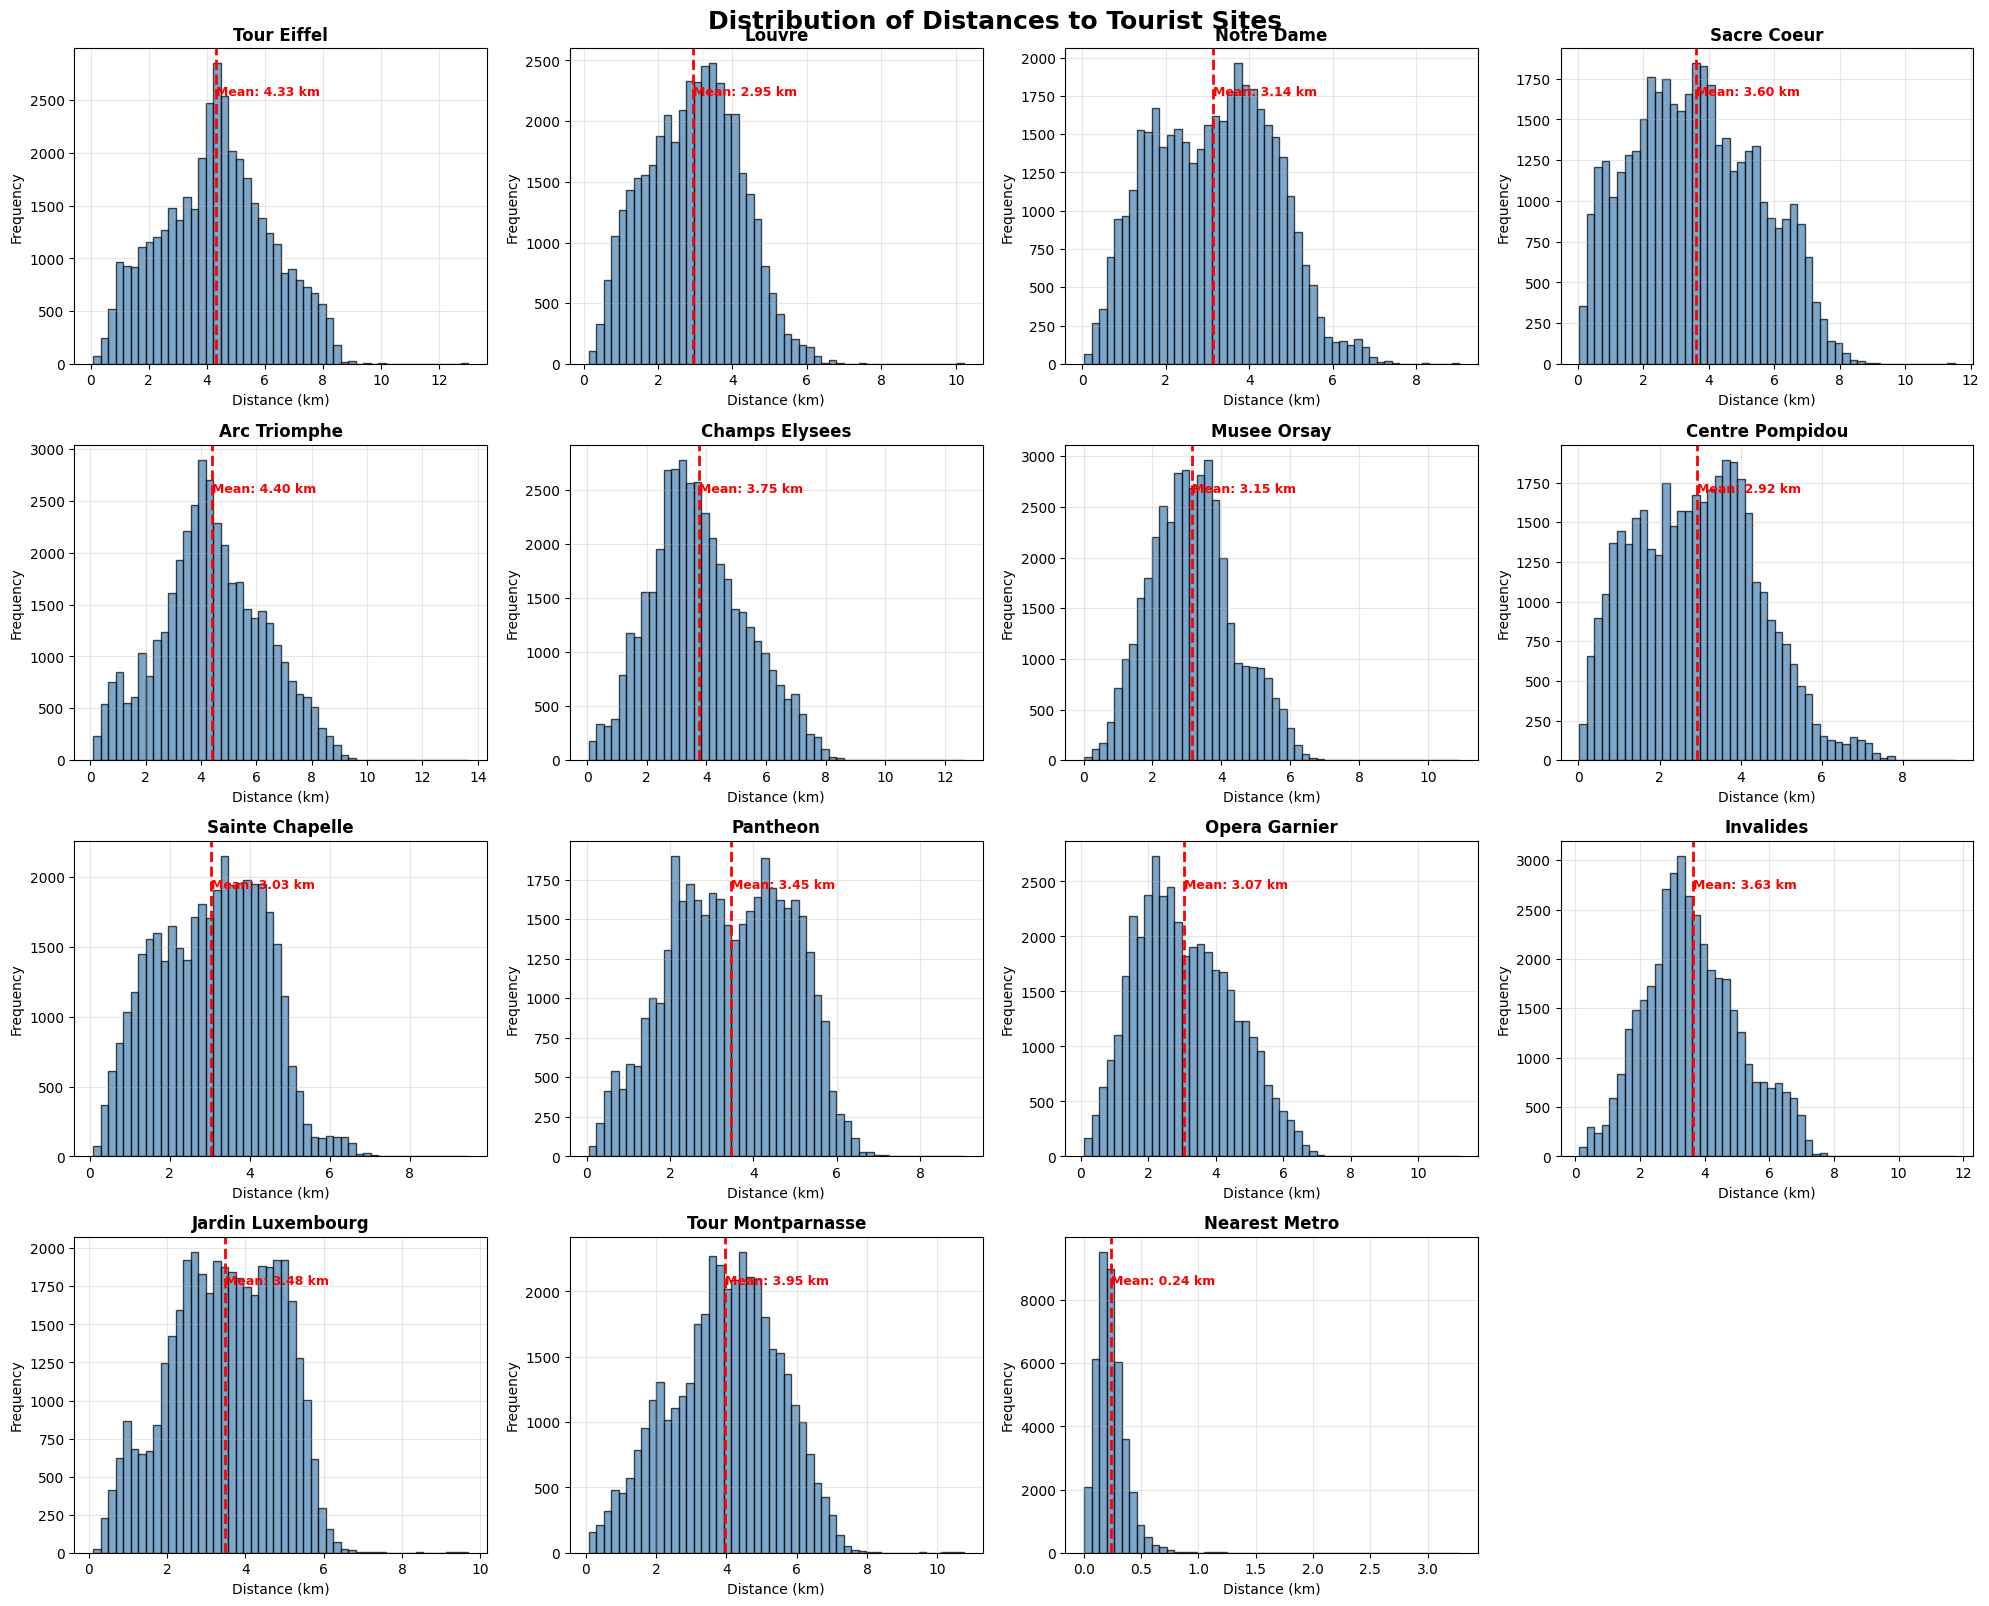

In [0]:
# Visualization 1: Distributions
print("Visualization 1: Distributions\n")

n_features = len(all_distance_features)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
axes = axes.flatten()

for i, col in enumerate(all_distance_features):
    ax = axes[i]
    local_train_pd[col].hist(bins=50, ax=ax, edgecolor='black', alpha=0.7, color='steelblue')
    
    feature_name = col.replace('dist_', '').replace('_', ' ').title()
    ax.set_title(feature_name, fontsize=12, fontweight='bold')
    ax.set_xlabel('Distance (km)', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    mean_dist = local_train_pd[col].mean()
    ax.axvline(mean_dist, color='red', linestyle='--', linewidth=2)
    ax.text(mean_dist, ax.get_ylim()[1]*0.85, f'Mean: {mean_dist:.2f} km', 
            fontsize=9, color='red', fontweight='bold')

for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.suptitle('Distribution of Distances to Tourist Sites', y=1.001, fontsize=18, fontweight='bold')
plt.show()


##### Distribution of Distances to Tourist Sites

These histograms show how Airbnb listings are geographically distributed around each of the 15 distance features (14 major tourist sites + nearest metro station).

**Key Observations:**
- **Red vertical line:** Mean distance for each site
- **Shape analysis:** Most distributions are right-skewed → Many listings are relatively close, with a long tail of distant properties
- **Metro (bottom-right):** Extremely concentrated distribution (peak near 0.24 km) → Confirms excellent metro coverage across Paris


This visualization validates that our distance features have sufficient variance to be predictive. If all listings were at the same distance, the feature would be useless. Here, we see clear variation for each site, justifying their inclusion in the model.

Visualization 2: Correlations



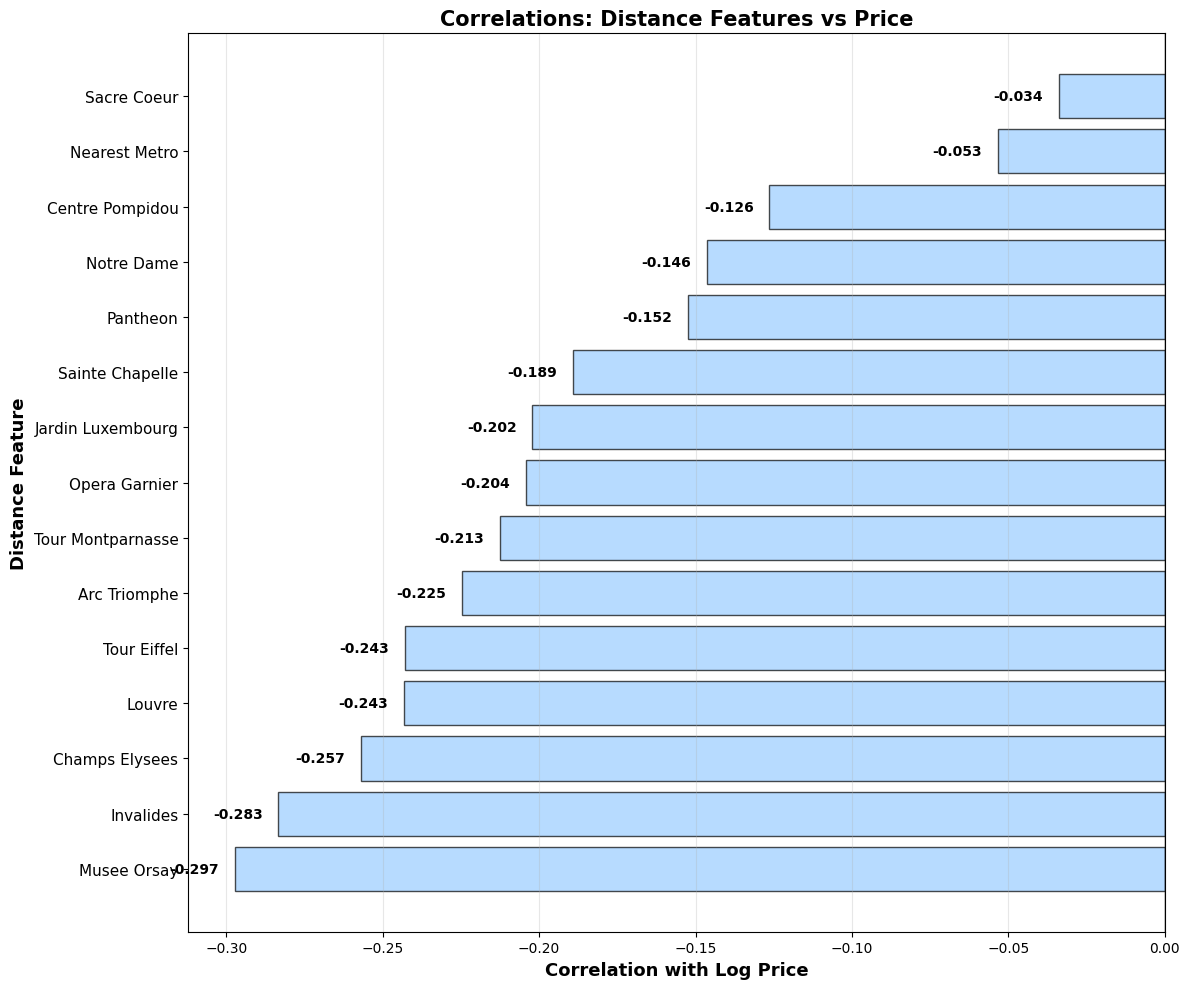


Top 5 positive correlations:
dist_pantheon          -0.152328
dist_notre_dame        -0.146297
dist_centre_pompidou   -0.126370
dist_nearest_metro     -0.053358
dist_sacre_coeur       -0.033799
Name: log_price, dtype: float64

Bottom 5 negative correlations:
dist_musee_orsay      -0.297349
dist_invalides        -0.283371
dist_champs_elysees   -0.257112
dist_louvre           -0.243273
dist_tour_eiffel      -0.242983
Name: log_price, dtype: float64


In [0]:
# Visualization 2: Correlations
print("Visualization 2: Correlations\n")

correlation_df = local_train_pd[all_distance_features + ['log_price']].corr()
price_correlations = correlation_df['log_price'].drop('log_price').sort_values()

plt.figure(figsize=(12, 10))


bars = plt.barh(range(len(price_correlations)), price_correlations.values, 
                color='#99CCFF', alpha=0.7, edgecolor='black', linewidth=1)


y_labels = [c.replace('dist_', '').replace('_', ' ').title() for c in price_correlations.index]
plt.yticks(range(len(price_correlations)), y_labels, fontsize=11)

plt.xlabel('Correlation with Log Price', fontsize=13, fontweight='bold')
plt.ylabel('Distance Feature', fontsize=13, fontweight='bold')
plt.title('Correlations: Distance Features vs Price', fontsize=15, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(True, alpha=0.3, axis='x')

for i, (bar, val) in enumerate(zip(bars, price_correlations.values)):
    x_pos = val + 0.005 if val > 0 else val - 0.005
    h_align = 'left' if val > 0 else 'right'
    plt.text(x_pos, i, f'{val:.3f}', va='center', ha=h_align, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nTop 5 positive correlations:")
print(price_correlations.tail(5))
print("\nBottom 5 negative correlations:")
print(price_correlations.head(5))


##### Interpretation: Continuous Distance Features

**Key Findings:**
- All distance features show negative correlation with price: the farther from tourist sites, the lower the price
- **Strongest correlations:** Musée d'Orsay (-0.297), Invalides (-0.283), Champs Elysées (-0.257)
- These features capture gradual distance effects (e.g., 0.5km vs 2km makes a difference)

**Metro Distance:**
- `dist_nearest_metro` shows **very weak correlation (-0.053)**
- **Why?** Paris has excellent metro coverage → 96.4% of listings are < 500m from a station
- **Conclusion:** Metro proximity is not a discriminating factor in Paris pricing

Visualization 3: Geographic Map



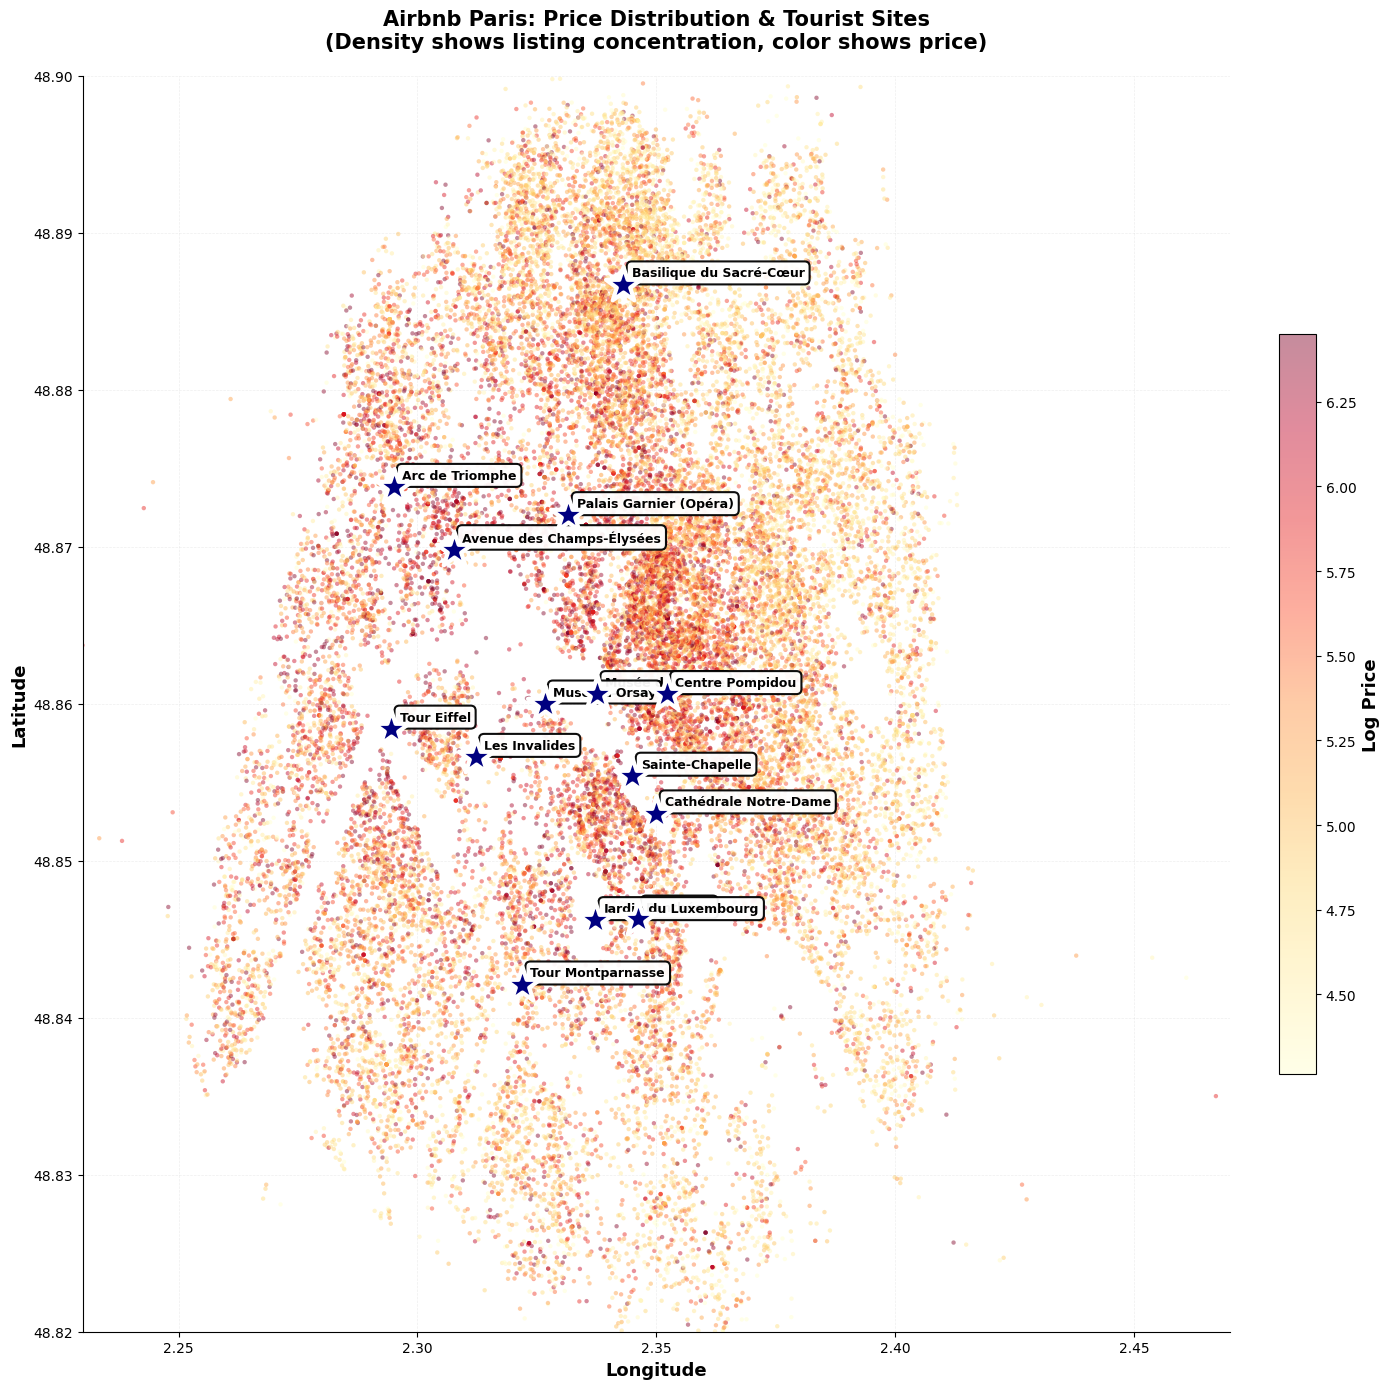

Map combines density visualization (point concentration) with price coloring


In [0]:
# Visualization 3: Geographic Map (Hybrid: Scatter + Density)
print("Visualization 3: Geographic Map\n")

import numpy as np
from scipy.stats import gaussian_kde

# Filter out Versailles
monuments_to_plot = monuments_pd[monuments_pd['monument_id'] != 'versailles'].copy()

fig, ax = plt.subplots(figsize=(14, 14))

# Sample data
sample_size = min(len(local_train_pd), 30000)
sample = local_train_pd.sample(sample_size, random_state=42)

# Create density estimation
x = sample['longitude'].values
y = sample['latitude'].values
z = sample['log_price'].values

# Calculate point density
xy = np.vstack([x, y])
density = gaussian_kde(xy)(xy)

# Sort by density
idx = density.argsort()
x, y, z, density = x[idx], y[idx], z[idx], density[idx]

# CALCULATE COLOR RANGE for better contrast
vmin = np.percentile(z, 5)   # 5th percentile (avoid extreme low values)
vmax = np.percentile(z, 95)  # 95th percentile (avoid extreme high values)

# Scatter plot - WITH ADJUSTED COLOR RANGE
scatter = ax.scatter(x, y, c=z, 
                     cmap='YlOrRd',
                     s=10,
                     alpha=0.45,
                     edgecolors='none',
                     rasterized=True,
                     vmin=vmin,  # ← ADD THIS
                     vmax=vmax)  # ← ADD THIS

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label('Log Price', fontsize=13, fontweight='bold')

# Monuments
ax.scatter(monuments_to_plot['longitude'], monuments_to_plot['latitude'],
           marker='*', s=700,
           c='navy', 
           edgecolors='white', linewidths=3, zorder=10)

# Labels
for idx, row in monuments_to_plot.iterrows():
    ax.annotate(row['name'], 
                xy=(row['longitude'], row['latitude']),
                xytext=(6, 6), textcoords='offset points',
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.4',
                         facecolor='white', 
                         alpha=0.95, 
                         edgecolor='black',
                         linewidth=1.5))

# Zoom on Paris
ax.set_xlim(2.23, 2.47)
ax.set_ylim(48.82, 48.90)

# Styling
ax.set_xlabel('Longitude', fontsize=13, fontweight='bold')
ax.set_ylabel('Latitude', fontsize=13, fontweight='bold')
ax.set_title('Airbnb Paris: Price Distribution & Tourist Sites\n(Density shows listing concentration, color shows price)', 
             fontsize=15, fontweight='bold', pad=20)
ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print("Map combines density visualization (point concentration) with price coloring")

##### Geographic Distribution

This map visualizes the spatial relationship between Airbnb listings and major tourist sites:
- **Orange/Red points:** Individual listings (color intensity = price level)
- **Blue stars:** Major tourist attractions (14 sites)
- **Observation:** High-priced listings (darker red) concentrate around central tourist areas, confirming that proximity to landmarks strongly influences pricing.

Visualization: Price vs Distance for Top Correlated Sites



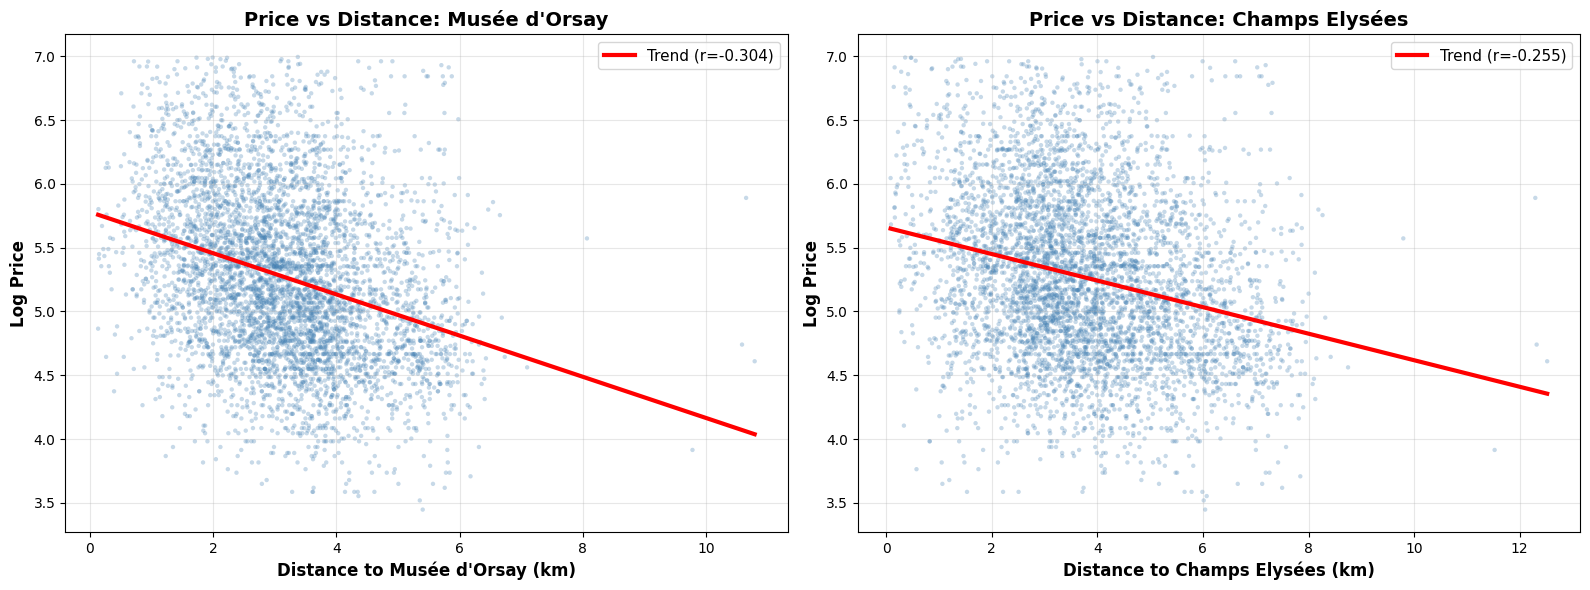

Visual confirmation: Negative relationship between distance and price


In [0]:
# Visualization: Price vs Distance (Top 2 Sites)
print("Visualization: Price vs Distance for Top Correlated Sites\n")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Select top 2 sites by absolute correlation
top_sites = ['dist_musee_orsay', 'dist_champs_elysees']
titles = ['Musée d\'Orsay', 'Champs Elysées']

for ax, site, title in zip(axes, top_sites, titles):
    # Sample for performance (max 5000 points)
    sample = local_train_pd.sample(min(5000, len(local_train_pd)), random_state=42)
    
    # Scatter plot
    ax.scatter(sample[site], sample['log_price'], 
               alpha=0.3, s=10, c='steelblue', edgecolors='none')
    
    # Add regression line
    from scipy.stats import linregress
    slope, intercept, r, p, se = linregress(sample[site], sample['log_price'])
    x_line = np.linspace(sample[site].min(), sample[site].max(), 100)
    ax.plot(x_line, slope * x_line + intercept, 
            'r-', linewidth=3, label=f'Trend (r={r:.3f})')
    
    ax.set_xlabel(f'Distance to {title} (km)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Log Price', fontsize=12, fontweight='bold')
    ax.set_title(f'Price vs Distance: {title}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

print("Visual confirmation: Negative relationship between distance and price")

##### Price vs Distance: Visual Confirmation

**Key Findings:**
- **Clear negative trend:** Both plots show price decreasing as distance increases (downward red trend lines)
- **Musée d'Orsay (left):** r = -0.304 → Stronger correlation
- **Champs Elysées (right):** r = -0.255 → Moderate correlation
- **Interpretation:** These scatter plots visually confirm what correlation coefficients showed — distance to major sites is a meaningful predictor of listing prices in Paris.

**Section 8**: EXPERIMENTATION - Binary Features

Testing binary "proximity" features.

 **Approach**:
 - Create binary features: "Near tourist site?" (< 1km threshold)
 - Compare correlations: Continuous vs Binary
 - Select best performing features

In [0]:
# Create binary features
THRESHOLD_KM = 1.0  # 1 km ≈ 15 minutes walking

# Major tourist sites (the 6 most popular)
major_sites_cols = [
    'dist_tour_eiffel', 'dist_louvre', 'dist_notre_dame',
    'dist_arc_triomphe', 'dist_champs_elysees', 'dist_musee_orsay'
]

# Feature 1: Proximity to at least ONE major site?
local_train_pd['near_any_major_site'] = (
    local_train_pd[major_sites_cols].min(axis=1) < THRESHOLD_KM
).astype(int)

test_pd['near_any_major_site'] = (
    test_pd[major_sites_cols].min(axis=1) < THRESHOLD_KM
).astype(int)

# Feature 2: Number of major sites within 1 km
local_train_pd['num_sites_nearby'] = (
    local_train_pd[major_sites_cols] < THRESHOLD_KM
).sum(axis=1)

test_pd['num_sites_nearby'] = (
    test_pd[major_sites_cols] < THRESHOLD_KM
).sum(axis=1)

# Feature 3: Far from the metro?
local_train_pd['far_from_metro'] = (
    local_train_pd['dist_nearest_metro'] > 0.5
).astype(int)

test_pd['far_from_metro'] = (
    test_pd['dist_nearest_metro'] > 0.5
).astype(int)

print("3 binary features created")



3 binary features created


In [0]:
# Statistics
print(f"\nStatistics for binary features:")
print(f"   • Listings near a major site: {local_train_pd['near_any_major_site'].sum():,} ({local_train_pd['near_any_major_site'].mean()*100:.1f}%)")
print(f"   • Average number of nearby sites: {local_train_pd['num_sites_nearby'].mean():.2f}")
print(f"   • Listings far from the metro: {local_train_pd['far_from_metro'].sum():,} ({local_train_pd['far_from_metro'].mean()*100:.1f}%)")



Statistics for binary features:
   • Listings near a major site: 8,189 (20.3%)
   • Average number of nearby sites: 0.26
   • Listings far from the metro: 1,451 (3.6%)


##### Binary Features: Exploratory Analysis

As part of our feature engineering process, we explored binary representations of proximity to test whether there are threshold effects in pricing near tourist sites.

**Hypothesis Tested:**
There's a "premium zone" within 1km of major sites where prices jump significantly

**Binary Features Created:**
1. `near_any_major_site`: Listing is within 1km of at least one major site
2. `num_sites_nearby`: Count of major sites within 1km
3. `far_from_metro`: Listing is > 500m from nearest metro

**Why Test Binary Features?**
- **Interpretability:** "Near major site" is clearer than "2.3km away"
- **Threshold capture:** Being < 1km may trigger a qualitative difference (tourist hotspot)
- **Robustness:** Less sensitive to outliers (10km vs 11km = same)

**Exploratory Results:**
- **20.3%** of listings are near a major site (< 1km)
- Binary features show **positive correlation** with price (+0.220)
- Average price premium: **+6.9%** for listings near major sites

**Decision: Binary Features NOT Retained**

While the exploratory analysis confirmed that proximity to tourist sites impacts pricing, we ultimately chose to retain **only continuous distance features** for the following reasons:

1. **Greater information richness:** Continuous features capture granular distance effects (0.5km vs 2km matters)
2. **Stronger correlations:** Distance to major sites shows correlations up to -0.297 (vs +0.220 for binary)
3. **Model flexibility:** Random Forest and Gradient Boosting models automatically learn threshold effects from continuous features
4. **Reduced redundancy:** Binary features are derivable from continuous distances

**Conclusion:**
This exploratory analysis validated the importance of proximity to tourist sites in Paris pricing, confirming our continuous distance features are on the right track.


In [0]:
#Comparison of Correlations
print(f"\nComparison: Correlations with log_price\n")

# Continuous correlations (already calculated)
corr_continues = local_train_pd[major_sites_cols + ['log_price']].corr()['log_price'].drop('log_price')

# Binary correlations (new features)
binary_features = ['near_any_major_site', 'num_sites_nearby', 'far_from_metro']
corr_binaires = local_train_pd[binary_features + ['log_price']].corr()['log_price'].drop('log_price')

print("Continuous Features (distances in km):")
print(corr_continues.sort_values())

print("\nBinary Features (proximity):")
print(corr_binaires.sort_values())

print("\n" + "="*80)
print("Analysis:")
print("="*80)

max_corr_continue = abs(corr_continues).max()
max_corr_binaire = abs(corr_binaires).max()

print(f"   Max correlation (continuous): {max_corr_continue:.3f}")
print(f"   Max correlation (binary):  {max_corr_binaire:.3f}")

if max_corr_binaire > max_corr_continue:
    print(f"\n   The binary features are more correlated (+{((max_corr_binaire/max_corr_continue - 1)*100):.0f}%)")
    print(f"   → Recommendation: Keep the binary features")
else:
    print(f"\n   The continuous features are more correlated")
    print(f"   → Recommendation: Keep the continuous features")

print("="*80)


Comparison: Correlations with log_price

Continuous Features (distances in km):
dist_musee_orsay      -0.297349
dist_champs_elysees   -0.257112
dist_louvre           -0.243273
dist_tour_eiffel      -0.242983
dist_arc_triomphe     -0.224808
dist_notre_dame       -0.146297
Name: log_price, dtype: float64

Binary Features (proximity):
far_from_metro        -0.027116
num_sites_nearby       0.219413
near_any_major_site    0.219714
Name: log_price, dtype: float64

Analysis:
   Max correlation (continuous): 0.297
   Max correlation (binary):  0.220

   The continuous features are more correlated
   → Recommendation: Keep the continuous features


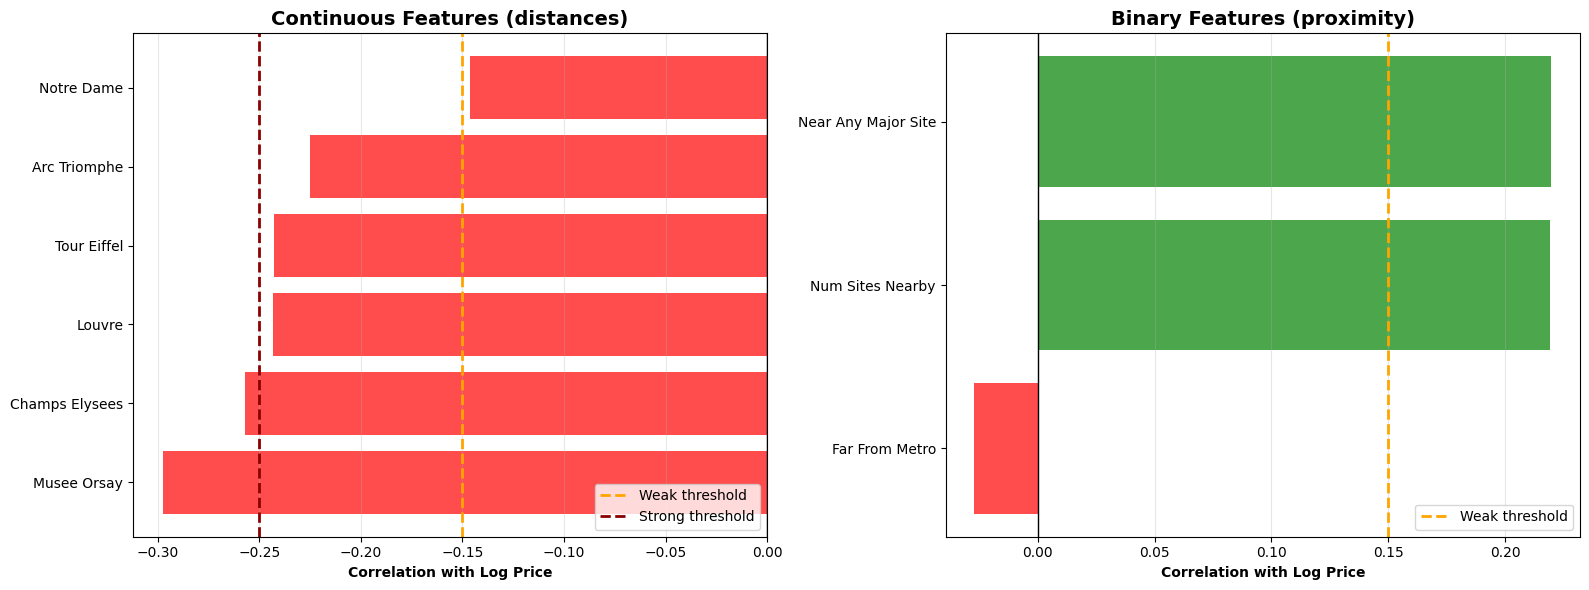


Comparative visualization created


In [0]:
# Comparative Visualization
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Continuous
corr_continues_sorted = corr_continues.sort_values()
colors1 = ['red' if x < 0 else 'green' for x in corr_continues_sorted.values]
ax1.barh(range(len(corr_continues_sorted)), corr_continues_sorted.values, color=colors1, alpha=0.7)
ax1.set_yticks(range(len(corr_continues_sorted)))
ax1.set_yticklabels([c.replace('dist_', '').replace('_', ' ').title() for c in corr_continues_sorted.index])
ax1.set_xlabel('Correlation with Log Price', fontweight='bold')
ax1.set_title('Continuous Features (distances)', fontsize=14, fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='-', linewidth=1)
# ADD THESE THRESHOLD LINES:
ax1.axvline(x=-0.15, color='orange', linestyle='--', linewidth=2, label='Weak threshold')
ax1.axvline(x=-0.25, color='darkred', linestyle='--', linewidth=2, label='Strong threshold')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3, axis='x')

# Plot 2: Binary
corr_binaires_sorted = corr_binaires.sort_values()
colors2 = ['red' if x < 0 else 'green' for x in corr_binaires_sorted.values]
ax2.barh(range(len(corr_binaires_sorted)), corr_binaires_sorted.values, color=colors2, alpha=0.7)
ax2.set_yticks(range(len(corr_binaires_sorted)))
ax2.set_yticklabels([c.replace('_', ' ').title() for c in corr_binaires_sorted.index])
ax2.set_xlabel('Correlation with Log Price', fontweight='bold')
ax2.set_title('Binary Features (proximity)', fontsize=14, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
# ADD THIS THRESHOLD LINE:
ax2.axvline(x=0.15, color='orange', linestyle='--', linewidth=2, label='Weak threshold')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\nComparative visualization created")

##### Binary vs Continuous Features

We tested both representations:
- **Continuous distances:** Direct distance in km (range: -0.297 to -0.034 correlation)
- **Binary proximity:** Whether listing is within 1km of any major site (+0.220 correlation)

**Decision: Retain only continuous distance features**

**Rationale:**
1. **Stronger predictive power:** Continuous features show higher correlation with price
2. **Model capability:** Random Forest models can automatically learn threshold effects from continuous features
3. **Reduced redundancy:** Binary features are derivable from continuous ones
4. **Simpler interpretation:** Focusing on one representation reduces feature complexity

The binary features served as exploratory analysis to confirm that proximity matters, but the continuous distances provide richer information to the model.

Creating key visualizations for binary features...



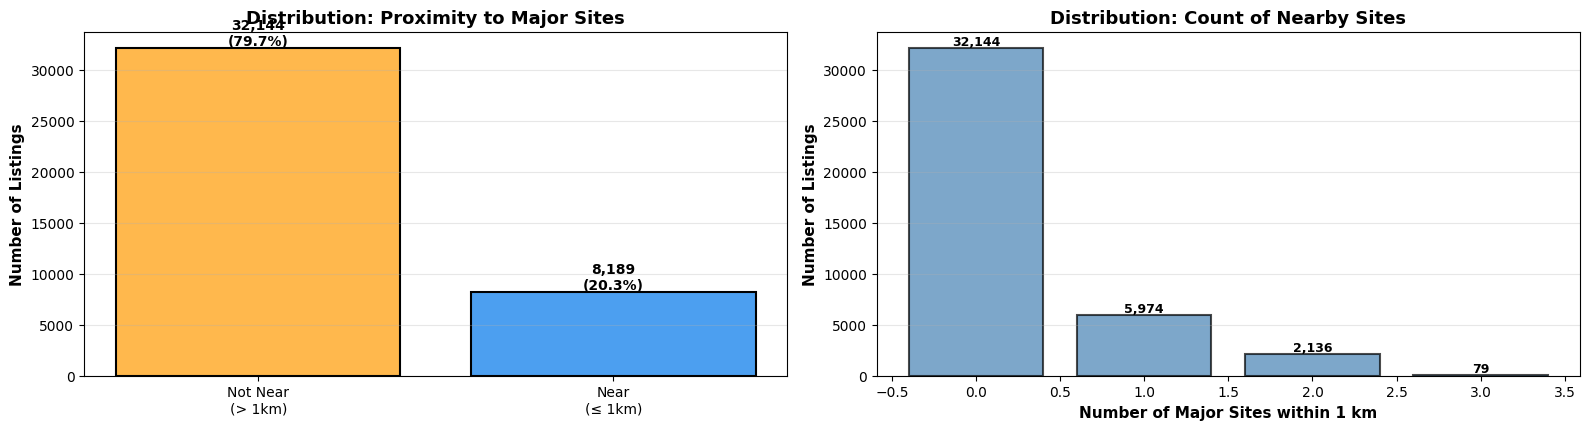

In [0]:
# Creating key visualizations for binary features
print("Creating key visualizations for binary features...\n")

fig = plt.figure(figsize=(16, 8))

# --- Visualization 1: Distribution Near/Not Near ---
ax1 = plt.subplot(2, 2, 1)
near_counts = local_train_pd['near_any_major_site'].value_counts()
colors = ['#FFB84D', '#4C9FF0']  # Orange-yellow for 'Not Near', Blue for 'Near'
bars = ax1.bar(['Not Near\n(> 1km)', 'Near\n(≤ 1km)'], near_counts.values, 
               color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Number of Listings', fontsize=11, fontweight='bold')
ax1.set_title('Distribution: Proximity to Major Sites', fontsize=13, fontweight='bold', color='black')
ax1.grid(True, alpha=0.3, axis='y')

for bar, count in zip(bars, near_counts.values):
    height = bar.get_height()
    pct = (count / len(local_train_pd)) * 100
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{count:,}\n({pct:.1f}%)',
             ha='center', va='bottom', fontweight='bold', fontsize=10)
# --- Visualization 2: Number of Sites Distribution ---
ax2 = plt.subplot(2, 2, 2)
site_counts = local_train_pd['num_sites_nearby'].value_counts().sort_index()
bars2 = ax2.bar(site_counts.index, site_counts.values, 
                color='steelblue', edgecolor='black', alpha=0.7, linewidth=1.5)
ax2.set_xlabel('Number of Major Sites within 1 km', fontsize=11, fontweight='bold')
ax2.set_ylabel('Number of Listings', fontsize=11, fontweight='bold')
ax2.set_title('Distribution: Count of Nearby Sites', fontsize=13, fontweight='bold', color='black')
ax2.grid(True, alpha=0.3, axis='y')

for bar, count in zip(bars2, site_counts.values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{count:,}',
             ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()


##### Distribution Analysis: Binary Features

**Exploratory Analysis:**
As part of our feature engineering process, we explored binary representations of proximity to major sites as an alternative to continuous distance features.

**Graph 1 - Proximity to Major Sites:**
- 79.7% of listings are NOT near a major site (> 1km away)
- 20.3% are in the "premium zone" (≤ 1km from at least one major site)
- This creates a clear segmentation between tourist and non-tourist areas

**Graph 2 - Number of Nearby Sites:**
- Most listings (0 sites nearby): 32,144 (79.7%)
- Listings with 1 site: 5,974
- Listings with 2+ sites: Rare but valuable (concentrated in central Paris)
- **Insight:** Having multiple sites nearby is uncommon and likely commands a premium

**Note:** While these binary features showed interesting patterns, we ultimately decided to retain only continuous distance features for the final model (see "Binary vs Continuous Features" section below for detailed rationale).


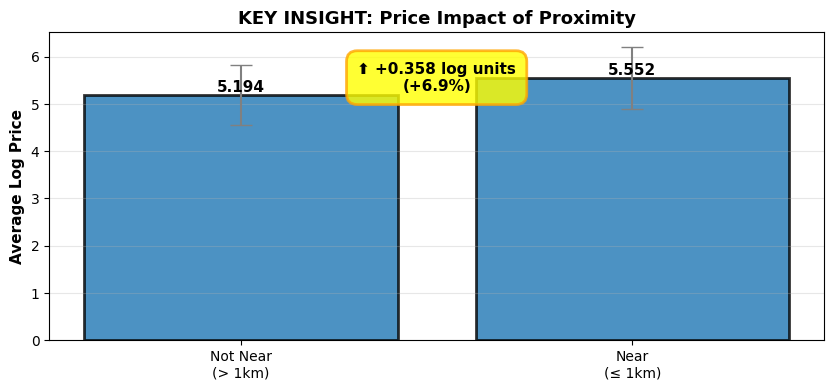

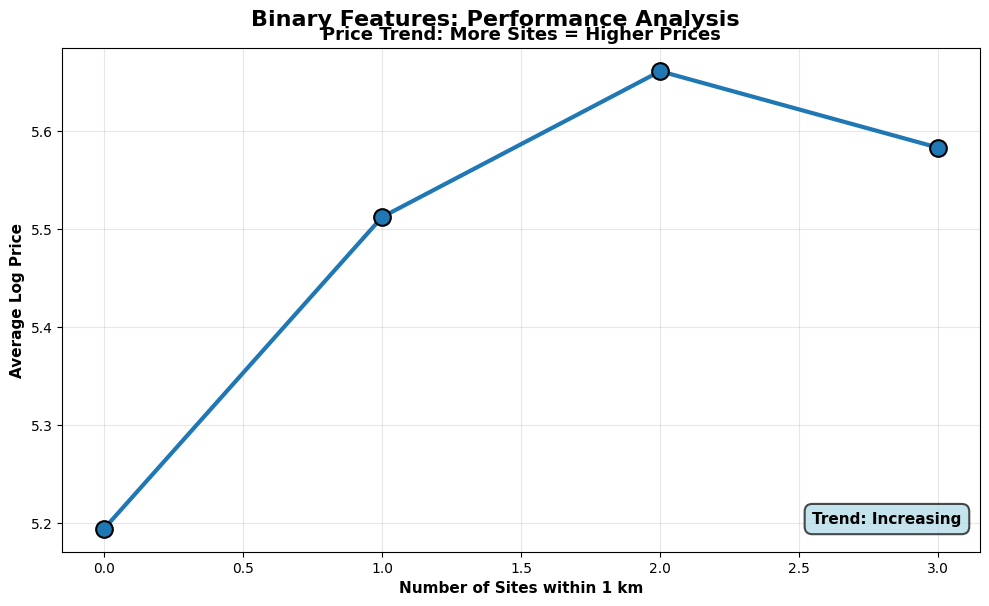

In [0]:
# --- Visualization 3: MAIN INSIGHT - Price Comparison ---
fig, ax3 = plt.subplots(figsize=(10, 4))

price_by_proximity = local_train_pd.groupby('near_any_major_site')['log_price'].mean()
price_std = local_train_pd.groupby('near_any_major_site')['log_price'].std()

x_pos = [0, 1]
labels = ['Not Near\n(> 1km)', 'Near\n(≤ 1km)']
bars3 = ax3.bar(x_pos, price_by_proximity.values, color='#1f77b4',  # Changing to blue
                edgecolor='black', linewidth=2,
                yerr=price_std.values, capsize=8, alpha=0.8, ecolor='gray')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(labels)
ax3.set_ylabel('Average Log Price', fontsize=11, fontweight='bold')
ax3.set_title('KEY INSIGHT: Price Impact of Proximity', 
              fontsize=13, fontweight='bold', color='black')
ax3.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars3, price_by_proximity.values):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.3f}',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

price_diff = price_by_proximity.iloc[1] - price_by_proximity.iloc[0]
price_diff_pct = (price_diff / price_by_proximity.iloc[0]) * 100
ax3.text(0.5, price_by_proximity.max() * 0.95,
         f'⬆ +{price_diff:.3f} log units\n({price_diff_pct:+.1f}%)',
         ha='center', fontsize=11, fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.7', facecolor='yellow', 
                   alpha=0.8, edgecolor='orange', linewidth=2))

# --- Visualization 4: Price Trend by Number of Sites ---
fig, ax4 = plt.subplots(figsize=(10, 6))

price_by_num_sites = local_train_pd.groupby('num_sites_nearby')['log_price'].mean()
ax4.plot(price_by_num_sites.index, price_by_num_sites.values, 
         marker='o', linewidth=3, markersize=12, color='#1f77b4',  # Changing to blue
         markeredgecolor='black', markeredgewidth=1.5)
ax4.set_xlabel('Number of Sites within 1 km', fontsize=11, fontweight='bold')
ax4.set_ylabel('Average Log Price', fontsize=11, fontweight='bold')
ax4.set_title('Price Trend: More Sites = Higher Prices', 
              fontsize=13, fontweight='bold', color='black')
ax4.grid(True, alpha=0.3)

if len(price_by_num_sites) > 1:
    trend = "Increasing" if price_by_num_sites.iloc[-1] > price_by_num_sites.iloc[0] else "Decreasing"
    trend_color = 'lightblue' if "Increasing" in trend else 'lightcoral'
    ax4.text(0.98, 0.05, f'Trend: {trend}', transform=ax4.transAxes,
             ha='right', va='bottom', fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor=trend_color, 
                       alpha=0.7, edgecolor='black', linewidth=1.5))

plt.tight_layout()
plt.suptitle('Binary Features: Performance Analysis', 
             y=1.002, fontsize=16, fontweight='bold')
plt.show()



##### KEY INSIGHT: Price Impact of Proximity

**Exploratory Binary Features Analysis:**
We tested binary features to understand if there's a threshold effect in pricing near tourist sites.

**Top Graph - Average Price Comparison:**
- **Not Near (> 1km):** Average log price = 5.194
- **Near (≤ 1km):** Average log price = 5.552
- **Difference:** +0.358 log units = **+6.9% price premium**
- **Finding:** Clear price advantage for listings near major sites

**Bottom Graph - Price Trend by Number of Sites:**
- Clear positive trend: More nearby sites → Higher average price
- **Peak at 2 sites:** ~5.68 log price (highest average)

**Decision:**
While binary features showed significant correlation (+0.220), we ultimately retained **continuous distance features** for our final model because:
1. **Greater information richness:** Continuous features capture granular distance effects (0.5km vs 2km matters)
2. **Stronger correlations:** Distance to major sites shows correlations up to -0.297 (vs +0.220 for binary)
3. **Model flexibility:** Random Forest and Gradient Boosting models can automatically learn threshold effects from continuous features
4. **Reduced redundancy:** Binary features are derivable from continuous distances

**Conclusion:** This exploratory analysis confirmed that proximity to tourist sites is a strong price predictor for Paris listings, validating our feature engineering approach.

Final Feature Selection

In [0]:
print("="*80)
print("FINAL FEATURE SELECTION")
print("="*80 + "\n")

# Calculate correlations (excluding Versailles)
all_distance_cols = [col for col in local_train_pd.columns 
                     if col.startswith('dist_') and col != 'dist_versailles']
corr_all_distances = local_train_pd[all_distance_cols + ['log_price']].corr()['log_price'].drop('log_price')

print("SELECTED FEATURES:")
print(f"   • All {len(all_distance_cols)} continuous distance features")
print(f"       → Range: {corr_all_distances.min():.3f} to {corr_all_distances.max():.3f}")
print(f"       → Top 3: {', '.join(corr_all_distances.nsmallest(3).index.str.replace('dist_', ''))}")

print("\nREJECTED FEATURES:")
print(f"   • Binary/count features (near_any_major_site, num_sites_nearby)")
print(f"       → Reason: Redundant with continuous distances (model can learn thresholds)")
print(f"   • far_from_metro (binary) → Correlation: -0.027 (too weak)")
print(f"   • nearest_metro_name (categorical) → Redundant with distance")
print(f"   • dist_versailles → Geographically outside Paris")

print("\nRATIONALE:")
print("   • Continuous distances provide richer information")
print("   • Random Forest/Gradient Boosting models capture threshold effects automatically")
print("   • Simplified feature set with stronger correlations")

# Drop rejected features
features_to_drop = ['near_any_major_site', 'num_sites_nearby', 'far_from_metro', 'nearest_metro_name']
local_train_pd = local_train_pd.drop(columns=features_to_drop, errors='ignore')
test_pd = test_pd.drop(columns=features_to_drop, errors='ignore')

print(f"\n   Dropped {len(features_to_drop)} features\n")

# Final list
final_paris_features = [col for col in local_train_pd.columns if col.startswith('dist_')]

print("="*80)
print(f"FINAL PARIS-SPECIFIC FEATURES: {len(final_paris_features)}")
print("="*80 + "\n")

for f in sorted(final_paris_features, key=lambda x: corr_all_distances[x]):
    corr = corr_all_distances[f]
    status = "STRONG" if abs(corr) > 0.20 else "MODERATE" if abs(corr) > 0.10 else "WEAK"
    print(f"   [{status:8}] {f:35} → {corr:+.4f}")

print("="*80 + "\n")


FINAL FEATURE SELECTION

SELECTED FEATURES:
   • All 15 continuous distance features
       → Range: -0.297 to -0.034
       → Top 3: musee_orsay, invalides, champs_elysees

REJECTED FEATURES:
   • Binary/count features (near_any_major_site, num_sites_nearby)
       → Reason: Redundant with continuous distances (model can learn thresholds)
   • far_from_metro (binary) → Correlation: -0.027 (too weak)
   • nearest_metro_name (categorical) → Redundant with distance
   • dist_versailles → Geographically outside Paris

RATIONALE:
   • Continuous distances provide richer information
   • Random Forest/Gradient Boosting models capture threshold effects automatically
   • Simplified feature set with stronger correlations

   Dropped 4 features

FINAL PARIS-SPECIFIC FEATURES: 15

   [STRONG  ] dist_musee_orsay                    → -0.2973
   [STRONG  ] dist_invalides                      → -0.2834
   [STRONG  ] dist_champs_elysees                 → -0.2571
   [STRONG  ] dist_louvre            

##### Summary: Paris-Specific Feature Engineering

**Features Created:**
- 3 binary/count features (exploratory analysis of proximity thresholds)
- 15 continuous distance features (14 major tourist sites + nearest metro)

**Final Selected Features:**
After comprehensive analysis and testing, we retained **15 continuous distance features only**:

**Retained (15 features):**
- Distance to 14 major Paris landmarks (Tour Eiffel, Louvre, Musée d'Orsay, Champs Elysées, Invalides, Arc de Triomphe, Centre Pompidou, Jardin Luxembourg, Notre Dame, Opéra Garnier, Panthéon, Sacré Coeur, Sainte Chapelle, Tour Montparnasse)
- Distance to nearest metro station (for documentation, despite weak correlation)

**Rejected (5 features):**
- Binary proximity features (near_any_major_site, num_sites_nearby) → Redundant with continuous distances
- far_from_metro → Too weak correlation (-0.027) due to excellent metro coverage
- nearest_metro_name → Categorical, redundant with distance
- dist_versailles → Geographically outside Paris (~17km)

**Rationale:**
1. **Stronger predictive power:** Continuous features show correlations up to -0.297 (vs +0.220 for binary)
2. **Model flexibility:** Random Forest/Gradient Boosting models automatically learn thresholds from continuous features
3. **Information richness:** Continuous distances capture granular effects (0.5km vs 2km matters)
4. **Reduced redundancy:** Simplified feature set focusing on most informative representation

**Key Insights:**
1. Proximity to tourist sites is a **significant price factor** (up to -0.30 correlation)
2. Metro coverage is **too uniform** in Paris to be predictive (96.4% of listings < 500m)
3. Binary features served as **exploratory validation** that proximity matters, but continuous distances provide richer information

**Impact:**
- v4 datasets: 26 columns (from Data Analysis notebook)
- v5 datasets: 41 columns (+15 Paris-specific distance features)
- Files saved to: `/FileStore/tables/paris_project/gold/local_train_pool_v5_with_paris_features.parquet`

These Paris-specific features will be integrated into the local model training pipeline.

Section 9: Save Dataset v5

In [0]:
# ============================================================================
# FINAL STEP: SAVE ENRICHED DATASETS (v5)
# ============================================================================

print("\n" + "="*80)
print("SAVING ENRICHED DATASETS (v5) WITH PARIS-SPECIFIC FEATURES")
print("="*80 + "\n")

# Convert pandas back to Spark
print("Converting pandas DataFrames to Spark...")
local_train_v5_spark = spark.createDataFrame(local_train_pd)
test_v5_spark = spark.createDataFrame(test_pd)

print("Conversion complete")
print(f"   - local_train: {local_train_v5_spark.count():,} rows x {len(local_train_v5_spark.columns)} columns")
print(f"   - test: {test_v5_spark.count():,} rows x {len(test_v5_spark.columns)} columns")

# Save v5
print(f"\nSaving enriched datasets...")
print(f"   Destination: {BASE_PATH}")

print(f"\n   Saving local_train_pool_v5_with_paris_features.parquet...")
local_train_v5_spark.coalesce(1).write.mode("overwrite").parquet(LOCAL_TRAIN_OUTPUT)
print(f"   Saved successfully")

print(f"\n   Saving test_set_v5_with_paris_features.parquet...")
test_v5_spark.coalesce(1).write.mode("overwrite").parquet(TEST_OUTPUT)
print(f"   Saved successfully")

print("\n" + "="*80)
print("ALL PARIS-ENRICHED DATASETS (v5) SUCCESSFULLY SAVED")
print("="*80)

# Summary
print("\nENRICHMENT SUMMARY: v4 -> v5")
print("-" * 80)

original_cols = len(local_train_spark.columns)
enriched_cols = len(local_train_pd.columns)
added_cols = enriched_cols - original_cols

print(f"\nDataset sizes:")
print(f"   - local_train: {len(local_train_pd):,} rows")
print(f"   - test: {len(test_pd):,} rows")

print(f"\nColumn counts:")
print(f"   - Original (v4): {original_cols} columns")
print(f"   - Enriched (v5): {enriched_cols} columns")
print(f"   - Added: +{added_cols} Paris-specific features")

print(f"\nNew Paris-specific features:")
paris_features = sorted([col for col in local_train_pd.columns if col.startswith('dist_')])
for i, feat in enumerate(paris_features, 1):
    print(f"   {i:2d}. {feat}")

print("\nFiles saved to:")
print(f"   - {LOCAL_TRAIN_OUTPUT}")
print(f"   - {TEST_OUTPUT}")

print("\n" + "="*80)
print("PARIS-SPECIFIC FEATURES NOTEBOOK COMPLETE")
print("="*80)
print("\nNext step: Use v5 files in the Training notebook")
print(f"   Path: {BASE_PATH}")


SAVING ENRICHED DATASETS (v5) WITH PARIS-SPECIFIC FEATURES

Converting pandas DataFrames to Spark...
Conversion complete
   - local_train: 40,333 rows x 89 columns
   - test: 10,935 rows x 89 columns

Saving enriched datasets...
   Destination: /FileStore/tables/paris_project

   Saving local_train_pool_v5_with_paris_features.parquet...
   Saved successfully

   Saving test_set_v5_with_paris_features.parquet...
   Saved successfully

ALL PARIS-ENRICHED DATASETS (v5) SUCCESSFULLY SAVED

ENRICHMENT SUMMARY: v4 -> v5
--------------------------------------------------------------------------------

Dataset sizes:
   - local_train: 40,333 rows
   - test: 10,935 rows

Column counts:
   - Original (v4): 74 columns
   - Enriched (v5): 89 columns
   - Added: +15 Paris-specific features

New Paris-specific features:
    1. dist_arc_triomphe
    2. dist_centre_pompidou
    3. dist_champs_elysees
    4. dist_invalides
    5. dist_jardin_luxembourg
    6. dist_louvre
    7. dist_musee_orsay
    8.